In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.metrics import confusion_matrix,classification_report,precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn import svm, datasets
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import seaborn as sns

In [2]:
df = pd.read_csv('./data/dataset_scaled2.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1055 entries, 0 to 1054
Data columns (total 67 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   acc_x_max   1055 non-null   float64
 1   acc_y_max   1055 non-null   float64
 2   acc_z_max   1055 non-null   float64
 3   gyr_x_max   1055 non-null   float64
 4   gyr_y_max   1055 non-null   float64
 5   gyr_z_max   1055 non-null   float64
 6   acc_x_min   1055 non-null   float64
 7   acc_y_min   1055 non-null   float64
 8   acc_z_min   1055 non-null   float64
 9   gyr_x_min   1055 non-null   float64
 10  gyr_y_min   1055 non-null   float64
 11  gyr_z_min   1055 non-null   float64
 12  acc_x_mean  1055 non-null   float64
 13  acc_y_mean  1055 non-null   float64
 14  acc_z_mean  1055 non-null   float64
 15  gyr_x_mean  1055 non-null   float64
 16  gyr_y_mean  1055 non-null   float64
 17  gyr_z_mean  1055 non-null   float64
 18  acc_x_med   1055 non-null   float64
 19  acc_y_med   1055 non-null  

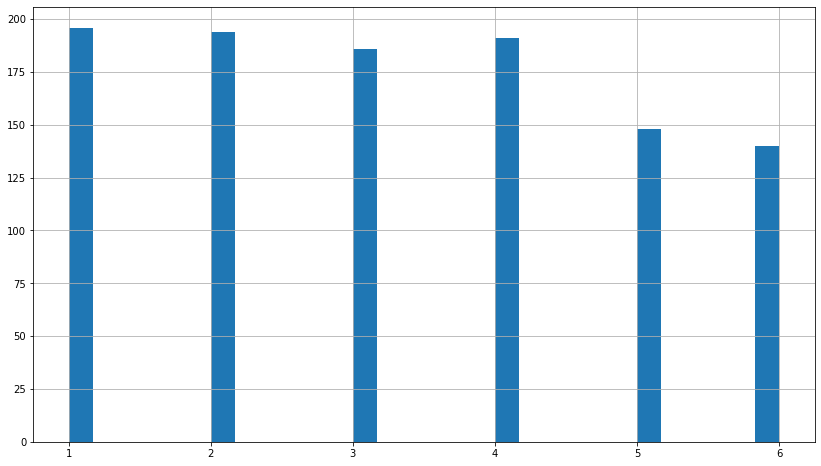

In [4]:
df['class'].hist(bins=30,figsize=(14,8))
plt.show()

In [5]:
X = df.iloc[:,0:-1]
y = df.iloc[:,-1]

In [6]:
for c in X.columns:
    X[c] = (X[c].values - X[c].values.min(0)) / X[c].values.ptp(0)

In [7]:
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)
fit

SelectKBest(score_func=<function chi2 at 0x7fc89f6f19d0>)

In [8]:
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score').values)  #print 10 best features
#print(featureScores.values)

[['acc_y_p25' 155.80985376371]
 ['acc_y_min' 121.77678776966044]
 ['acc_x_max' 104.76462367340591]
 ['acc_z_max' 103.43080911529738]
 ['gyr_y_med' 97.46950364327776]
 ['gyr_x_max' 84.53030795414108]
 ['acc_x_p75' 84.01345836422509]
 ['gyr_z_p25' 81.17566464011833]
 ['gyr_x_skw' 80.65706349812088]
 ['acc_x_skw' 75.79968999433473]]


In [9]:
X_small = X[featureScores.nlargest(25,'Score')['Specs'].values]

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1055 samples in 0.003s...
[t-SNE] Computed neighbors for 1055 samples in 0.084s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1055
[t-SNE] Computed conditional probabilities for sample 1055 / 1055
[t-SNE] Mean sigma: 0.223158
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.407242
[t-SNE] KL divergence after 2000 iterations: 0.377398


<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

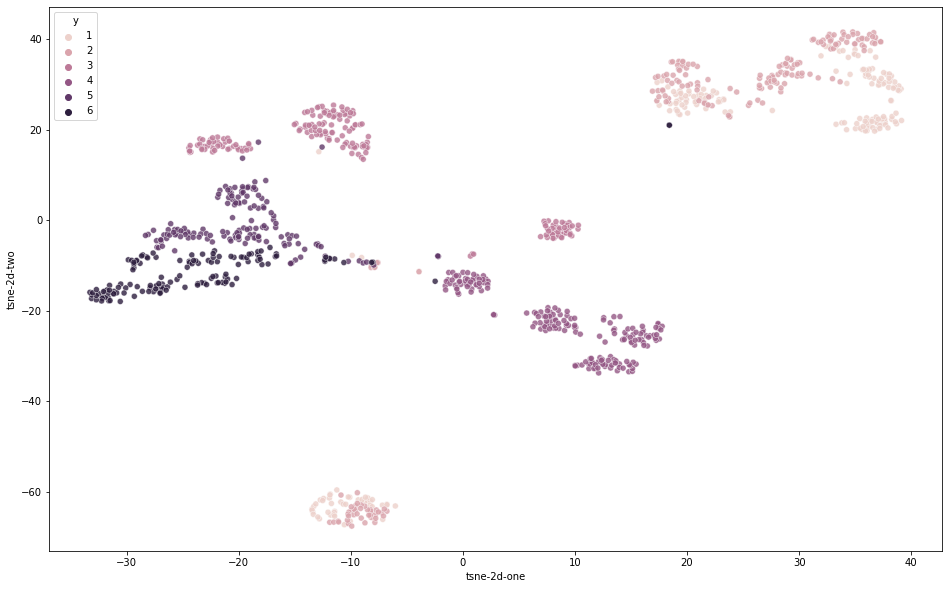

In [10]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=2000)
tsne_results = tsne.fit_transform(X_small.values)
plt.figure(figsize=(16,10))
df_subset = pd.DataFrame()
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
df_subset['y']=y
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    data=df_subset,
    legend="full",
    alpha=0.8
)

# 

In [11]:
poly_ = []
rbf_ = []
for size in np.array((range(len(X.columns))))[1:]:
    print('FOR SIZE',size,'\n\n')
    X_small = X[featureScores.nlargest(size,'Score')['Specs'].values]
    X_train, X_test, y_train, y_test = train_test_split(X_small, y, train_size=0.7, random_state = 0)
    rbf = svm.SVC(kernel='rbf', gamma=1, C=1, decision_function_shape='ovo').fit(X_train, y_train)
    poly = svm.SVC(kernel='poly', degree=4, C=1, decision_function_shape='ovo').fit(X_train, y_train)
    poly_pred = poly.predict(X_test)
    rbf_pred = rbf.predict(X_test)
    # retrieve the accuracy and print it for all 4 kernel functions
    accuracy_poly = poly.score(X_test, y_test)
    accuracy_rbf = rbf.score(X_test, y_test)
    print("Accuracy Polynomial Kernel:", accuracy_poly)
    print("Accuracy Radial Basis Kernel:", accuracy_rbf)
    #print(classification_report(y_test, rbf_pred))
    #print(classification_report(y_test, poly_pred))
    

    prec,rec,fs,_ = precision_recall_fscore_support(y_test,poly_pred,average='macro')
    poly_.append([prec,rec,fs])
    prec,rec,fs,_ = precision_recall_fscore_support(y_test,rbf_pred,average='macro')
    rbf_.append([prec,rec,fs])
poly_ = np.array(poly_)
rbf_ = np.array(rbf_)


FOR SIZE 1 


Accuracy Polynomial Kernel: 0.45425867507886436
Accuracy Radial Basis Kernel: 0.45425867507886436
FOR SIZE 2 


Accuracy Polynomial Kernel: 0.637223974763407
Accuracy Radial Basis Kernel: 0.5899053627760252
FOR SIZE 3 




/home/kavarakis/anaconda3/envs/su/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy Polynomial Kernel: 0.722397476340694
Accuracy Radial Basis Kernel: 0.668769716088328
FOR SIZE 4 


Accuracy Polynomial Kernel: 0.8138801261829653
Accuracy Radial Basis Kernel: 0.7413249211356467
FOR SIZE 5 


Accuracy Polynomial Kernel: 0.889589905362776
Accuracy Radial Basis Kernel: 0.8580441640378549
FOR SIZE 6 


Accuracy Polynomial Kernel: 0.889589905362776
Accuracy Radial Basis Kernel: 0.8738170347003155
FOR SIZE 7 


Accuracy Polynomial Kernel: 0.8990536277602523
Accuracy Radial Basis Kernel: 0.8643533123028391
FOR SIZE 8 


Accuracy Polynomial Kernel: 0.9116719242902208
Accuracy Radial Basis Kernel: 0.8643533123028391
FOR SIZE 9 


Accuracy Polynomial Kernel: 0.9022082018927445
Accuracy Radial Basis Kernel: 0.8738170347003155
FOR SIZE 10 


Accuracy Polynomial Kernel: 0.8990536277602523
Accuracy Radial Basis Kernel: 0.8769716088328076
FOR SIZE 11 


Accuracy Polynomial Kernel: 0.917981072555205
Accuracy Radial Basis Kernel: 0.8738170347003155
FOR SIZE 12 


Accuracy Pol

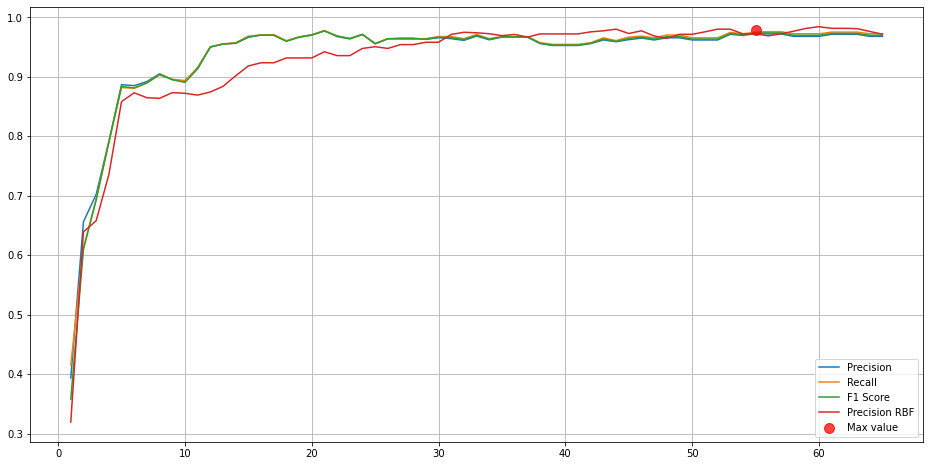

In [12]:
plt.rcParams["figure.figsize"] = (16,8)
plt.plot(list(range(1,len(X.columns))),poly_[:,0],label='Precision')
plt.plot(list(range(1,len(X.columns))),poly_[:,1],label='Recall')
plt.plot(list(range(1,len(X.columns))),poly_[:,2],label='F1 Score')
plt.scatter(55,np.amax(poly_),color='r',label='Max value',zorder=20,alpha=0.75,s=100)
plt.plot(list(range(1,len(X.columns))),rbf_[:,0],label='Precision RBF')
plt.legend()
plt.grid()
plt.show()

In [13]:
np.where(poly_ == np.amax(poly_))

(array([20]), array([1]))

In [14]:
np.savetxt('svm.csv',rbf_)

In [15]:
    X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7, random_state = 0)
    rbf = svm.SVC(kernel='rbf', gamma=1, C=1, decision_function_shape='ovo').fit(X_train, y_train)
    poly = svm.SVC(kernel='poly', degree=4, C=1, decision_function_shape='ovo').fit(X_train, y_train)
    poly_pred = poly.predict(X_test)
    rbf_pred = rbf.predict(X_test)
    # retrieve the accuracy and print it for all 4 kernel functions
    accuracy_poly = poly.score(X_test, y_test)
    accuracy_rbf = rbf.score(X_test, y_test)
    print("Accuracy Polynomial Kernel:", accuracy_poly)
    print("Accuracy Radial Basis Kernel:", accuracy_rbf)
    print(classification_report(y_test, rbf_pred))
    print(classification_report(y_test, poly_pred))

Accuracy Polynomial Kernel: 0.9779179810725552
Accuracy Radial Basis Kernel: 0.9747634069400631
              precision    recall  f1-score   support

           1       0.96      0.96      0.96        48
           2       0.97      0.95      0.96        60
           3       1.00      1.00      1.00        62
           4       1.00      0.97      0.98        64
           5       0.97      1.00      0.99        35
           6       0.94      0.98      0.96        48

    accuracy                           0.97       317
   macro avg       0.97      0.98      0.97       317
weighted avg       0.98      0.97      0.97       317

              precision    recall  f1-score   support

           1       0.96      0.96      0.96        48
           2       0.97      0.93      0.95        60
           3       1.00      1.00      1.00        62
           4       1.00      1.00      1.00        64
           5       0.92      1.00      0.96        35
           6       1.00      0.98   

In [16]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14, vmax=100):
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)
    fig = plt.figure(figsize=figsize)
    cmap = sns.cubehelix_palette(n_colors=50, hue=0.1, rot=0, light=0.9, dark=0, as_cmap=True)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt="d", cmap=cmap, vmax=vmax, cbar=False)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.close(fig)
    return fig

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state = 0)
clf =svm.SVC(kernel='rbf',  C=1, decision_function_shape='ovo')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
labels = ["Forward-Backward Dribbling","Left-Right Dribbling","Regular Dribbling","Two Hands Dribbling","Shooting","Layup"]
cm = confusion_matrix(y_test, y_pred)


In [18]:
fig = print_confusion_matrix(cm,[1,2,3,4,5,6])
fig.savefig('cm_svm.png')